# tuningTest (A1)

In [1]:
import librosa
import librosa.display

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
#load data
assets = r"D:\z_Downloads\Datenset_Zauberfloete\data"
x_name = "WAM-79__Track2_Channel1.wav"
x_offset = 0
x_duration = 15
x_path = assets + "\\" + x_name
x_figTitle = x_name +" (" + str(x_offset) + "s - " + str(x_offset + x_duration) + "s)"

y_name = "WAM-46__Track1_Channel1.wav"
y_offset = 0
y_duration = 100
y_path = assets + "\\" + y_name
y_figTitle = y_name +" (" + str(y_offset) + "s - " + str(y_offset + y_duration) + "s)"

sampleRate = 22050
x_data, sr = librosa.load(path= x_path, sr= sampleRate, offset= x_offset, duration= x_duration)
y_data, sr = librosa.load(path= y_path, sr= sampleRate, offset= y_offset, duration= y_duration)

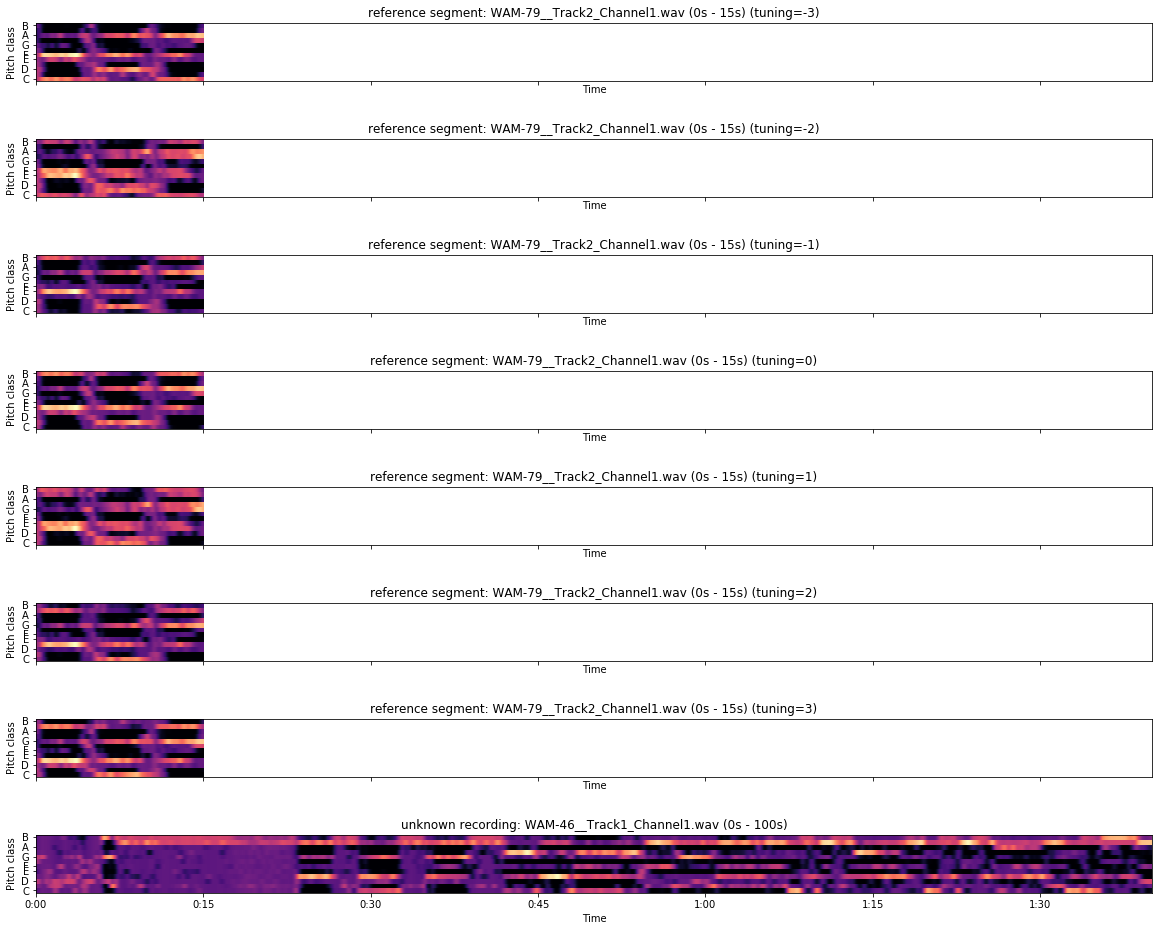

In [3]:
#feature extraction 
hopLength = 512
tuningRange = 3 # [-3,-2,-1,0,1,2,3]
hz = sampleRate / hopLength # ~2.69

x_chroma_tuned = {}
for x_tuning in range(-tuningRange, tuningRange + 1):
    x_chroma = librosa.feature.chroma_cens(x_data, sr=sampleRate, hop_length= hopLength, tuning= x_tuning)
    x_chroma_tuned.update({str(x_tuning): x_chroma})

y_chroma = librosa.feature.chroma_cens(y_data, sr=sampleRate, hop_length= hopLength)



#visualization
rows = tuningRange * 2 + 2
fig, ax = plt.subplots(nrows=rows, sharex=True, sharey=True, figsize=(20, 2 * rows))

i = 0
for x_tuning, x_chroma in x_chroma_tuned.items():
    librosa.display.specshow(x_chroma, y_axis='chroma', x_axis='time', ax=ax[i])
    ax[i].set(title= "reference segment: " + x_figTitle + " (tuning=" + x_tuning + ")")
    i = i + 1

librosa.display.specshow(y_chroma, y_axis='chroma', x_axis='time', ax=ax[rows -1])
ax[rows-1].set(title="unknown recording: " + y_figTitle)
fig.subplots_adjust(hspace = 0.1 * rows + 0.2)

tuning = -3, start: 00:00:02, end: 00:00:05, cost = 211
tuning = -2, start: 00:00:01, end: 00:00:06, cost = 194
tuning = -1, start: 00:00:01, end: 00:00:01, cost = 205
tuning = 0, start: 00:00:01, end: 00:00:06, cost = 218
tuning = 1, start: 00:00:54, end: 00:00:54, cost = 183
tuning = 2, start: 00:00:23, end: 00:00:39, cost = 117
tuning = 3, start: 00:00:23, end: 00:00:39, cost = 112


"\n#visualization old\n\nfig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20,5))\nimg = librosa.display.specshow(D, x_axis='frames', y_axis='frames', ax=ax[0])\nax[0].set(title='DTW cost', ylabel='Target')\nax[0].plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')\nax[0].legend()\n\nax[1].plot(D[-1, :] / wp.shape[0])\nax[1].set(xlim=[0, y_chroma.shape[1]], ylim=[0, 2], title='Matching cost function')\nfig.colorbar(img, ax=ax)\n\n"

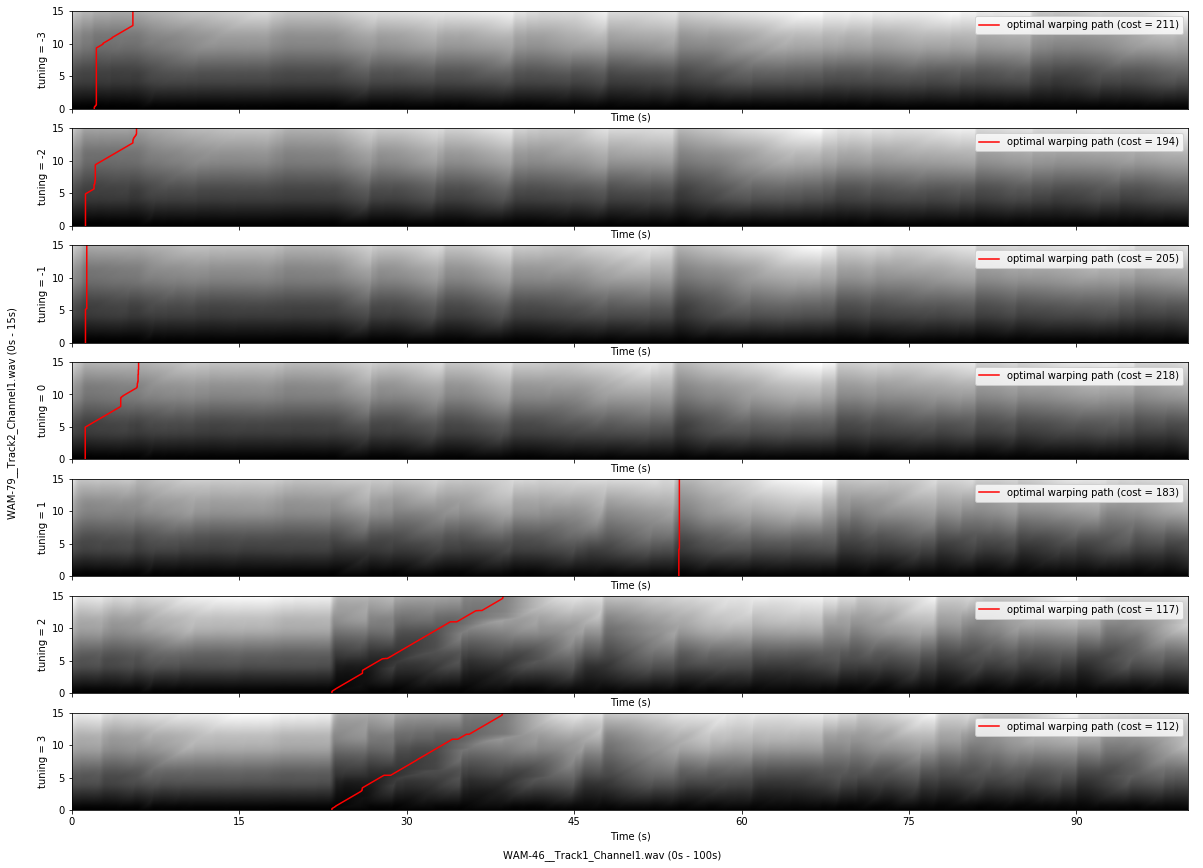

In [4]:
#dynamic time warping
#https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S2_DTWbasic.html
#https://librosa.org/doc/main/generated/librosa.sequence.dtw.html
import time

stepSizesSigma=np.array([[1, 0], [0, 1], [1, 1]])

dtw_tuned = {}
for x_tuning, x_chroma in x_chroma_tuned.items():
    dtw = librosa.sequence.dtw(x_chroma, y_chroma, metric='euclidean', step_sizes_sigma=stepSizesSigma, weights_add=np.array([0, 0, 0]), weights_mul=np.array([1, 1, 1]), subseq=True)
    dtw_tuned.update({str(x_tuning): dtw})


    
#visualization
rows = tuningRange * 2 + 1
fig, ax = plt.subplots(nrows=rows, sharex=True, sharey=True, figsize=(20, 2.1 * rows))

bestMatch = ["", 9999, 0, 0]
i = 0
for x_tuning, dtw in dtw_tuned.items():
    D, wp = dtw
    
    start_f = wp[-1][1]
    end_f = wp[0][1]
    
    start_s = int(round(start_f / hz)) 
    end_s = int(round(end_f / hz))
    
    cost = 0
    for y, x in wp:
        cost += D[y][x]
        
    cost = int(round(cost/len(wp))) #cost in relation to wp size (ref segment size)
    
    if cost < bestMatch[1]:
        bestMatch[0] = x_tuning
        bestMatch[1] = cost
        bestMatch[2] = start_s
        bestMatch[3] = end_s
    
    print("tuning = " + x_tuning + ", start: " + time.strftime('%H:%M:%S', time.gmtime(start_s)) + ", end: " + time.strftime('%H:%M:%S', time.gmtime(end_s))+", cost = " + str(cost))
    
    if rows > 1:
        AX = ax[i]
    else:
        AX = ax
        
    librosa.display.specshow(D, y_axis='s', x_axis='s', cmap='gray', ax=AX)
    AX.set_ylabel("tuning = " + x_tuning)
    AX.plot(wp[:, 1]/hz, wp[:, 0]/hz, label='optimal warping path (cost = ' + str(cost) + ')', color='r')
    AX.legend()

    i = i + 1

#fig.subplots_adjust(hspace = 0.1 * rows)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.text(0.5, 0.08, y_figTitle, ha='center')
fig.text(0.08, 0.5, x_figTitle, va='center', rotation='vertical')


"""
#visualization old

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20,5))
img = librosa.display.specshow(D, x_axis='frames', y_axis='frames', ax=ax[0])
ax[0].set(title='DTW cost', ylabel='Target')
ax[0].plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
ax[0].legend()

ax[1].plot(D[-1, :] / wp.shape[0])
ax[1].set(xlim=[0, y_chroma.shape[1]], ylim=[0, 2], title='Matching cost function')
fig.colorbar(img, ax=ax)

"""

In [5]:
from IPython.display import Audio, IFrame, display
y, sr = librosa.load(path= y_path, sr= sampleRate, offset = bestMatch[2], duration = bestMatch[3] - bestMatch[2])
display(Audio(y, rate = sr))

print(bestMatch)

['3', 112, 23, 39]
